# Performing mu-z cosmology fitting

In [ ]:
import cosmographi as cg
import caskade as ck
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

## Making a SN sample

In [2]:
# Define the simulator
cosmology = cg.Cosmology()
rateIa = cg.sn.SNRateConst(cosmology, 1e-4, z_max = 2.0, name = "rateIa")
rateIbc = cg.sn.SNRateConst(cosmology, 5e-5, z_max = 2.0, name = "rateIbc")
ratecombined = cg.sn.CombinedSNRate((rateIa, rateIbc), z_max = 2.0, cosmology=cosmology)
detect_Ia = cg.sn.MuSigmoidDetect(threshold=15, scale=0.1, name="detectIa")
detect_Ibc = cg.sn.MuSigmoidDetect(threshold=14, scale=0.1, name="detectIbc")

# Define sampling parameters
n_samples = 1000
var_mu_Ia = lambda z: 0.2**2 * z
var_z_Ia = lambda z: 0.1**2 * z
cov_Ia = lambda key, vmu, vz: jax.random.uniform(key, vmu.shape, minval= 0, maxval= jnp.sqrt(vmu*vz)*0.7)
var_mu_Ibc = lambda z: 1.5**2 * z
var_z_Ibc = lambda z: 0.2**2 * z
cov_Ibc = lambda key, vmu, vz: jax.random.uniform(key, vmu.shape, minval= 0, maxval= jnp.sqrt(vmu*vz)*0.7)

# Sample SN
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
# sample SN redshifts
z = ratecombined.sample(subkey, n_samples) 
# compute true distance modulus
DL = jax.vmap(cosmology.luminosity_distance)(z) 
mu = 5 * jnp.log10(DL) - 5
# sample SN types
t = []
for i in range(n_samples):
    key, subkey = jax.random.split(key)
    t.append(ratecombined.sample_type(subkey, z[i]))
t = jnp.array(t)
# determine observational uncertainties
var_mu = jnp.where(t == 0, var_mu_Ia(z), var_mu_Ibc(z))
var_z = jnp.where(t == 0, var_z_Ia(z), var_z_Ibc(z))
key, subkey1 = jax.random.split(key)
key, subkey2 = jax.random.split(key)
cov = jnp.where(t == 0, cov_Ia(subkey1, var_mu, var_z), cov_Ibc(subkey2, var_mu, var_z))
key, subkey = jax.random.split(key)
# sample observed redshift and distance modulus
obs = jax.random.multivariate_normal(key, mean = jnp.stack((z, mu), axis=-1), cov = jnp.stack((jnp.stack((var_z, cov), axis=-1), jnp.stack((cov, var_mu), axis=-1)), axis=-1))
obs_z, obs_mu = obs[:, 0], obs[:, 1]
# sample detections
detected = []
for i in range(n_samples):
    key, subkey = jax.random.split(key)
    if t[i] == 0:
        detected.append(detect_Ia.sample(subkey, obs_z[i], obs_mu[i]))
    else:
        detected.append(detect_Ibc.sample(subkey, obs_z[i], obs_mu[i]))
detected = jnp.array(detected)

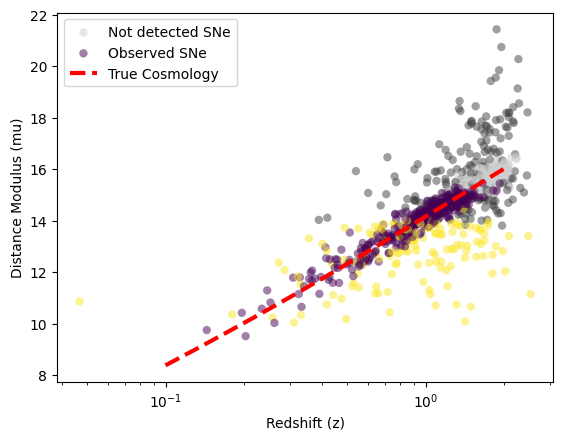

In [3]:
plt.scatter(obs_z[~detected], obs_mu[~detected], c=plt.get_cmap('Greys')(0.5*t[~detected]+0.3), alpha=0.5, label="Not detected SNe", linewidth =0)
plt.scatter(obs_z[detected], obs_mu[detected], c=t[detected], cmap='viridis', alpha=0.5, label="Observed SNe", linewidth =0)
z_line = jnp.linspace(0.1, 2, 1000)
plt.plot(z_line, 5*jnp.log10(jax.vmap(cosmology.luminosity_distance)(z_line))-5, 'r--', label='True Cosmology', linewidth = 3)
plt.xlabel('Redshift (z)')
plt.xscale("log")
plt.ylabel("Distance Modulus (mu)")
plt.legend()
plt.show()

## Construct posterior density

In [ ]:
cosmo_mean = [0.307, -1] # Omega_m, w
cosmo_cov = [[0.01, 0], [0, 0.01]]
cosmology.Omega_m.to_dynamic()
cosmology.w.to_dynamic()

detect_Ia_mean = [15, 0.1] # threshold, scale
detect_Ia_cov = [[1.0, 0], [0, 0.01]]
detect_Ia.threshold.to_dynamic()
detect_Ia.scale.to_dynamic()

detect_Ibc_mean = [14, 0.1] # threshold, scale
detect_Ibc_cov = [[1.0, 0], [0, 0.01]]
detect_Ibc.threshold.to_dynamic()
detect_Ibc.scale.to_dynamic()


In [ ]:
class Posterior(ck.Module):
    def __init__(self, cosmology, rateIa, rateIbc, detect_Ia, detect_Ibc, obs_mean, obs_cov):
        self.cosmology = cosmology
        self.rate = [rateIa, rateIbc]
        self.detect = [detect_Ia, detect_Ibc]
        self.obs_mean = obs_mean
        self.obs_cov = obs_cov
        self.z = ck.Param("z", obs_mean[:,0])

    @ck.forward
    def log_posterior(self, z):
        log_posterior = 0

        # compute distance modulus
        DL = jax.vmap(self.cosmology.luminosity_distance)(z) 
        mu = 5 * jnp.log10(DL) - 5

        # cosmology prior
        c = jnp.array((self.cosmology.Omega_m.value, self.cosmology.w.value))
        r = c - cosmo_mean
        log_posterior += -0.5 * (jnp.dot(r, jnp.linalg.solve(cosmo_cov, r)) + jnp.linalg.slogdet(cosmo_cov)[1])

        for i in range(len(self.obs_mean)):
            for t in range(2):
                # detection likelihood
                log_posterior += self.detect[t].log_prob(self.obs_mean[i], self.obs_cov[i])
                # rate likelihood/prior
                log_posterior += self.rate[t].log_prob(self.obs_mean[i], self.obs_cov[i])
                # obs likelihood
        return log_posterior
